<a href="https://colab.research.google.com/github/rubeshajith/NYC-taxi-trip-time-prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

# Mounting of Drive, Importing libraries and Loading Data

In [42]:
# Mounting of google drive to feth the csv file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Libraries which are necessary and their importing.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from geopy.distance import great_circle
from scipy.stats import zscore

In [2]:
# Fetching the given csv file using pandas
df = pd.read_csv("/content/drive/MyDrive/data/project/NYC Taxi Data.csv")

# Information About The Data

In [3]:
#Total number of Rows and Columns in Dataset     
df.shape

(1458644, 11)

In [4]:
# Top 5 elements in our dataframe
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
# NULL/NAN values in given dataset
df[df.isnull()].sum()

id                      0
vendor_id             0.0
pickup_datetime         0
dropoff_datetime        0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag      0
trip_duration         0.0
dtype: object

Their are no NULL values in the given dataframe

In [6]:
# Number of unique elements in the dataset columns
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [7]:
# Information of the dataset given
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Converting 'pickup_datetime' and 'dropoff_datetime' column's datatype from object to datetime, So that we can use them for creating separate features such as date, month, time and few other variables

In [8]:
# Converting them into type 'datetime'
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

# Creation of Variables


In [9]:
# Creating the day name with help of datetime package
df["pickup_day"] = df["pickup_datetime"].dt.day_name()
df["dropoff_day"] = df["dropoff_datetime"].dt.day_name()

In [10]:
# Converting those days to numeric form:
df["pickup_day_no"] = df["pickup_day"].map({"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday": 3, "Thursday": 4, "Friday":5, "Saturday":6})
df["dropoff_day_no"] = df["dropoff_day"].map({"Sunday":0, "Monday":1, "Tuesday":2, "Wednesday": 3, "Thursday": 4, "Friday":5, "Saturday":6})

In [15]:
# Creating hour column with the help of pickup and dropoff datetime columns
df["pickup_hour"] = df["pickup_datetime"].dt.hour
df["dropoff_hour"] = df["dropoff_datetime"].dt.hour

In [11]:
# Creating month column with our datetime column
df["pickup_month"] = df["pickup_datetime"].dt.month
df["dropoff_month"] = df["dropoff_datetime"].dt.month

In [12]:
# Function to convert time of a day to certain period of the day
def time_of_the_day(x):
  '''Function to extract certain time 
  of the day'''
  if x in range(6,12):
    return "Morning"
  elif x in range(12,16):
    return "Afternoon"
  elif x in range(16,22):
    return "Evening"
  else: 
    return "Night"

In [16]:
# Creating new columns which consists of certain period of a day with help of 'apply' method in pandas
df["pickup_time_of_the_day"] = df["pickup_hour"].apply(time_of_the_day)
df["dropoff_time_of_the_day"] = df["dropoff_hour"].apply(time_of_the_day)

In [17]:
# Importing required package to calculate distances
from geopy.distance import great_circle
def cal_distance(pickup_latitude,pickup_logitude,dropoff_latitude,dropoff_longitude):
  
  '''Calculates distance with help of longitute
  and latitude features and return values of distance
  in kilometer'''
  
  start_coordinates = (pickup_latitude, pickup_logitude)
  stop_coordinates = (dropoff_latitude,dropoff_longitude)
  return great_circle(start_coordinates, stop_coordinates).km

In [18]:
# Creating distance variable in our dataframe
df["distance"] = df.apply(lambda x : cal_distance(x["pickup_latitude"],x["pickup_longitude"],x["dropoff_latitude"],x["dropoff_longitude"]),axis=1)

Using the distance and trip duration we can calculate speed.
Formula for speed is
speed = distance/timetaken

In [19]:
# Creating speed variable using distance and duration variables, speed variable units in km/hr
df['speed'] = (df.distance/(df.trip_duration/3600))

# Univariate Analysis

### trip_duration

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


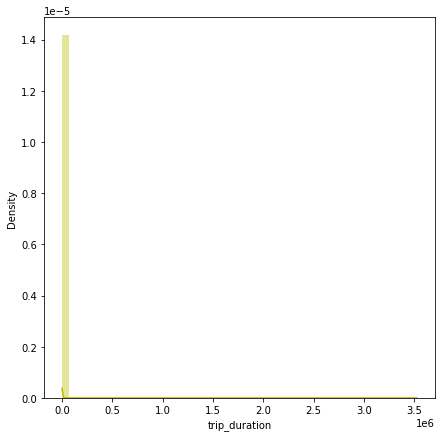

In [20]:
plt.figure(figsize=(7,7))
sns.distplot(df['trip_duration'],color="y")


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


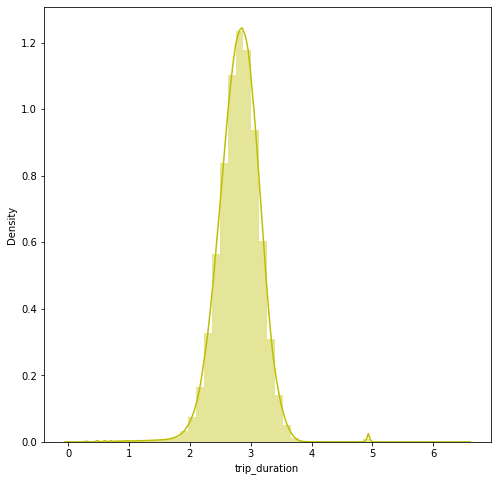

In [21]:
plt.figure(figsize= (8,8))
sns.distplot(np.log10(df.trip_duration), color="y")

After log transformation we can see that our targer variable is normally distrubuted


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


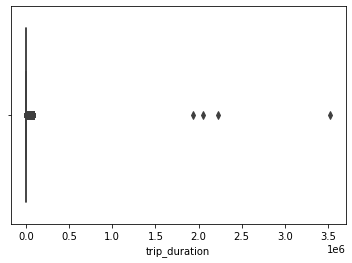

In [22]:
sns.boxplot(df.trip_duration)

We can see few outliers is our target variable


In [20]:
trip_duration_outliers = df['trip_duration'].sort_values(ascending= False).reset_index()
trip_duration_outliers[:4]

,index,trip_duration
0,978383,3526282
1,924150,2227612
2,680594,2049578
3,355003,1939736


This 4 data points where the outliers that we detected in boxplot

Here there are trips with more than 24hrs duration which is 86400 seconds upto 40 days which are outliers. We need to remove them for data consistency

In [24]:
# pd.reset_option("all")

In [21]:
pd.set_option("display.max_rows", 200)


In [22]:
pd.set_option("display.min_rows", 50)
# To observe the count of the trip duration with certain range we chose (1-3601)
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1, max(df.trip_duration)+3600,3600))).count()


trip_duration
(1, 3601]             1446313
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
(18001, 21601]             11
(21601, 25201]             11
(25201, 28801]             13
(28801, 32401]             17
(32401, 36001]              8
(36001, 39601]             13
(39601, 43201]              6
(43201, 46801]              8
(46801, 50401]              5
(50401, 54001]              7
(54001, 57601]              5
(57601, 61201]             10
(61201, 64801]             10
(64801, 68401]             10
(68401, 72001]              5
(72001, 75601]             10
(75601, 79201]             17
(79201, 82801]             63
(82801, 86401]           1839
(86401, 90001]              0
                       ...   
(3438001, 3441601]          0
(3441601, 3445201]          0
(3445201, 3448801]          0
(3448801, 3452401]          0
(3452401, 3456001]          0
(3456001, 3459601]          0
(3459601, 3463201]        

Most of the data fall in the 1st bucket which is within an hour trip

In [23]:
df[df.trip_duration > 86400].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_no,dropoff_day_no,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_time_of_the_day,dropoff_time_of_the_day,distance,speed
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2,3,1,1,0,11,Night,Morning,20.148692,0.037394
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,6,2,2,3,22,15,Night,Afternoon,5.982495,0.010508
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2,0,1,1,6,1,Morning,Night,1.635130,0.002643
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,6,5,2,3,22,18,Night,Evening,19.900690,0.020317


In [24]:
df.shape

(1458644, 23)

In [25]:
df[df.trip_duration < 60].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_no,dropoff_day_no,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_time_of_the_day,dropoff_time_of_the_day,distance,speed
72,id1510700,2,2016-02-20 21:58:13,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,N,...,6,6,2,2,21,21,Evening,Evening,0.328333,20.736824
323,id2954399,1,2016-06-27 11:22:37,2016-06-27 11:23:17,1,-74.001030,40.756653,-74.000999,40.756626,N,...,1,1,6,6,11,11,Morning,Morning,0.003927,0.353456
842,id3263580,2,2016-05-21 12:46:46,2016-05-21 12:46:49,2,-73.782372,40.648766,-73.782372,40.648746,N,...,6,6,5,5,12,12,Afternoon,Afternoon,0.002121,2.545053
853,id2730154,2,2016-03-29 22:39:46,2016-03-29 22:40:44,5,-73.982201,40.731812,-73.979950,40.734814,N,...,2,2,3,3,22,22,Night,Night,0.383931,23.830173
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,N,...,4,4,6,6,13,13,Afternoon,Afternoon,0.703066,1265.518471


Checking for trips taken within 0-30 mins.

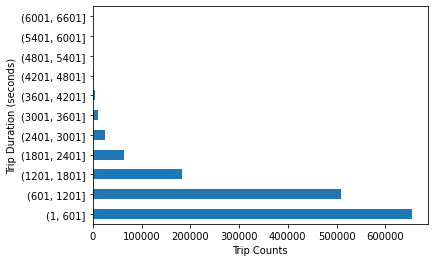

In [30]:
# Plot to compare time_duration with Trip counts
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

From the above plot we can see that most of the trip duration is completed within half an hour i.e, 30 mins(1800 seconds). Also there are very less trips that have duration more than 1800 seconds and some are as low as 1 second. We are removing trips between 0 and 60 secs, assuming trips with atleast 1 min(60sec) for data consistency in our model 

In [26]:
# Now to remove outliers i.e, trips with duration more than 86400 seconds.
df = df[df.trip_duration <= 86400]
# df = df[df.trip_duration >= 60]

### distance

In [27]:
df.distance.describe()

count    1.458640e+06
mean     3.440846e+00
std      4.296505e+00
min      0.000000e+00
25%      1.231836e+00
50%      2.093714e+00
75%      3.875328e+00
max      1.240910e+03
Name: distance, dtype: float64

In [28]:
print("Total number of trips with 0 distance are {}".format(df.distance[df["distance"] == 0].count()))

Total number of trips with 0 distance are 5897


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


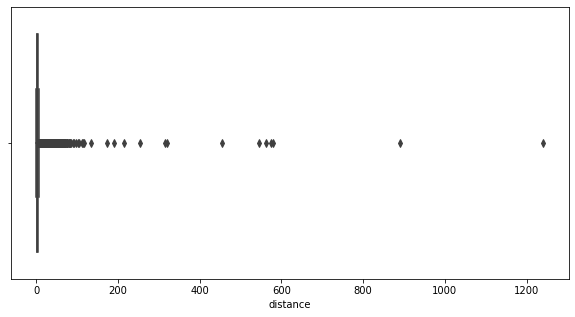

In [34]:
plt.figure(figsize = (10,5))
sns.boxplot(df.distance)
plt.show()

There are some trips with over 100 km distance.

Some of the trips distance value is 0 km.

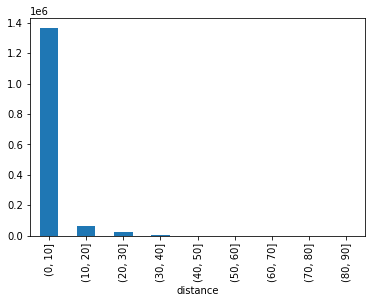

In [35]:
df.distance.groupby(pd.cut(df.distance, np.arange(0,100,10))).count().plot(kind= "bar")

From the above graph we can say that most of the trips are covered within 1-10 km , and few from 10-30 km. 

We are not removing 0 km distances, Assuming there might be technical error in gps system

### vendor id

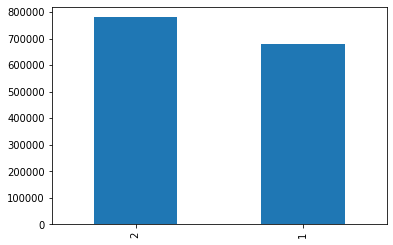

In [36]:
df["vendor_id"].value_counts().plot(kind="bar")

Vendor_id number 2 has committed more trips than vendor_id number 1

### Passenger Count

In [29]:
# Value counts of passenger_count feature
df['passenger_count'].value_counts()

1    1033537
2     210317
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

We can see passenger_count of 0 is less so we add it to highest passenger_count bucket which is 1

In [30]:
# We are assigning zero value of passenger count to bucket 1 using map method
df["passenger_count"] = df['passenger_count'].map(lambda x: 1 if x == 0 else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
df.shape

(1458640, 23)

In [32]:
# omitting number of passenger above 6
df = df[df["passenger_count"] <= 6]

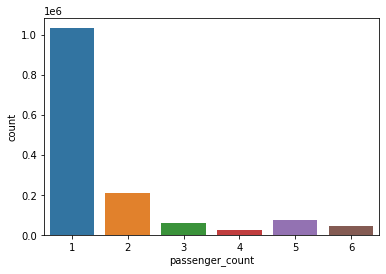

In [33]:
# Plotting passenger_count vs their counts
sns.countplot(x="passenger_count", data= df)

### Store and forward flag

In [34]:
df['store_and_fwd_flag'].value_counts()

N    1450590
Y       8045
Name: store_and_fwd_flag, dtype: int64

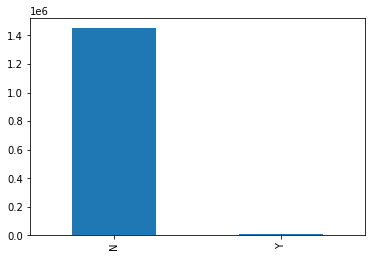

In [43]:
# Countplot for Store and Forward Flag
df['store_and_fwd_flag'].value_counts().plot(kind= "bar")

From Store and Forward Flag, we can see many of the data is not connected to server

In [72]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_no,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,pickup_time_of_the_day,dropoff_time_of_the_day,distance,speed
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1,1,17,17,3,3,Evening,Evening,1.498523,11.856445
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,0,0,0,6,6,Night,Night,1.805510,9.803673
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2,2,11,12,1,1,Morning,Afternoon,6.385108,10.822216
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,3,3,19,19,4,4,Evening,Evening,1.485501,12.465739
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6,6,13,13,3,3,Afternoon,Afternoon,1.188590,9.836608


Text(0.5, 1.0, 'Dropoff_days vs Count')

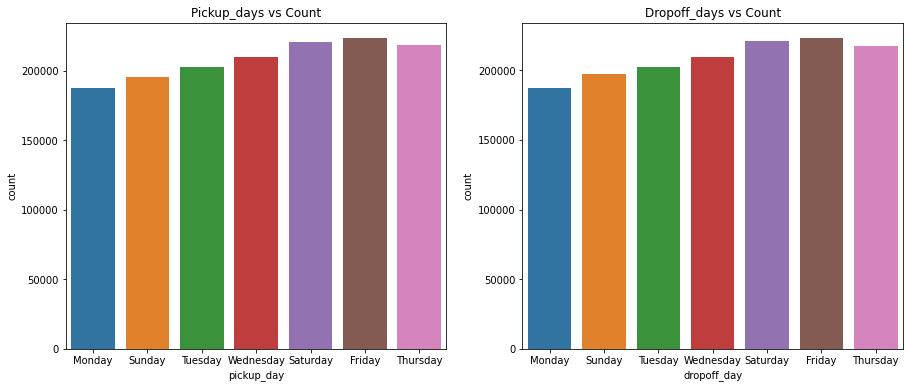

In [45]:
# plotting both pickup and dropoff days
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_day", data=df)
fig.set_title("Pickup_days vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_day", data= df)
fig.set_title("Dropoff_days vs Count")

Saturday and Friday are busiest than compared to weekdays

Text(0.5, 1.0, 'Dropoff_hour vs Count')

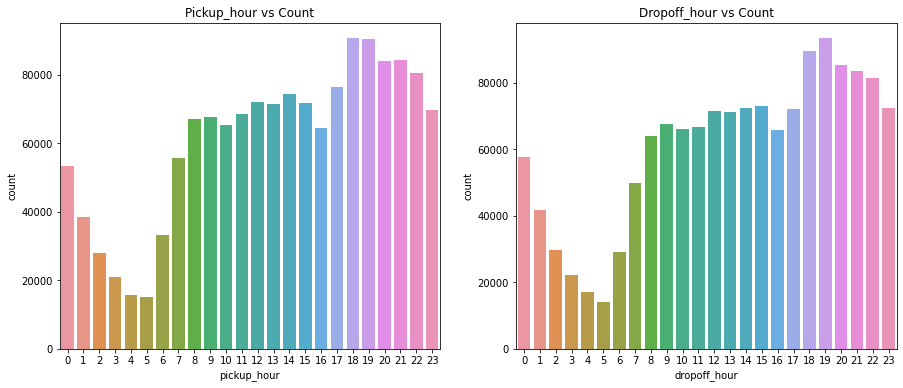

In [46]:
# plot for pickup and dropoff hours
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_hour", data=df)
fig.set_title("Pickup_hour vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_hour", data= df)
fig.set_title("Dropoff_hour vs Count")

Busy in peak hours which is from 6pm to 7pm

Text(0.5, 1.0, 'Dropoff_time_of_the_day vs Count')

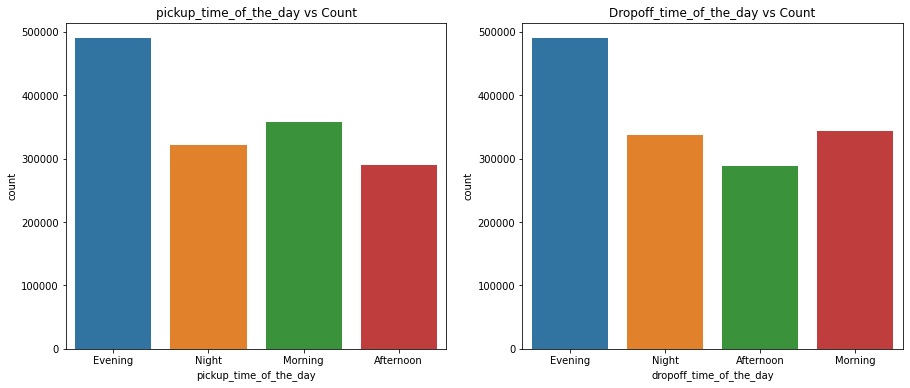

In [47]:
# plot for both pickup and dropoff period of time
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_time_of_the_day", data=df)
fig.set_title("pickup_time_of_the_day vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_time_of_the_day", data= df)
fig.set_title("Dropoff_time_of_the_day vs Count")

Evening and morning are busiest compared to others

Text(0.5, 1.0, 'Dropoff_monthy vs Count')

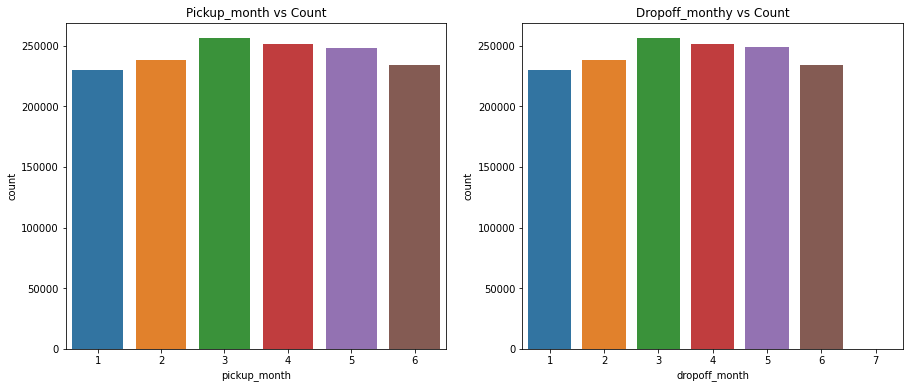

In [48]:
# plot for pickup and dropoff months
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x= "pickup_month", data=df)
fig.set_title("Pickup_month vs Count")
    
plt.subplot(1, 2, 2)
fig = sns.countplot(x= "dropoff_month", data= df)
fig.set_title("Dropoff_monthy vs Count")


Data consists of half year maybe, we see similar usage in months, March stands a bit higher rate compared to others

### Speed

In NYC the maximum speed limit 40 km/hr in urban areas and 104 km/hr on highways.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


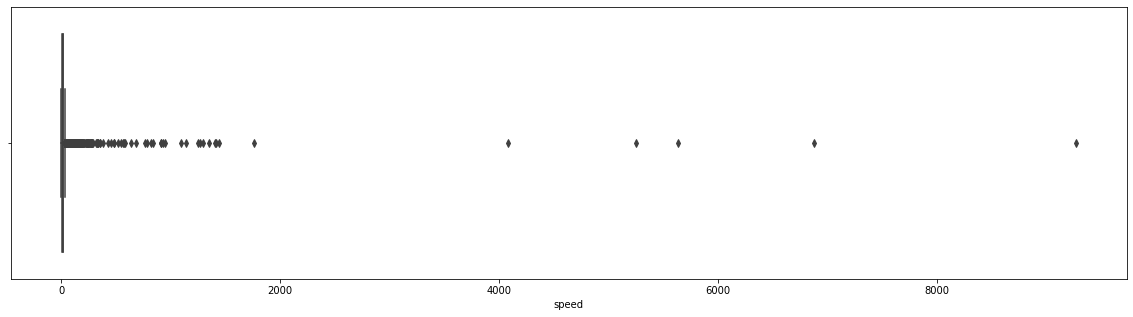

In [49]:
# Box plot for speed to check outliers
plt.figure(figsize = (20,5))
sns.boxplot(df.speed)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


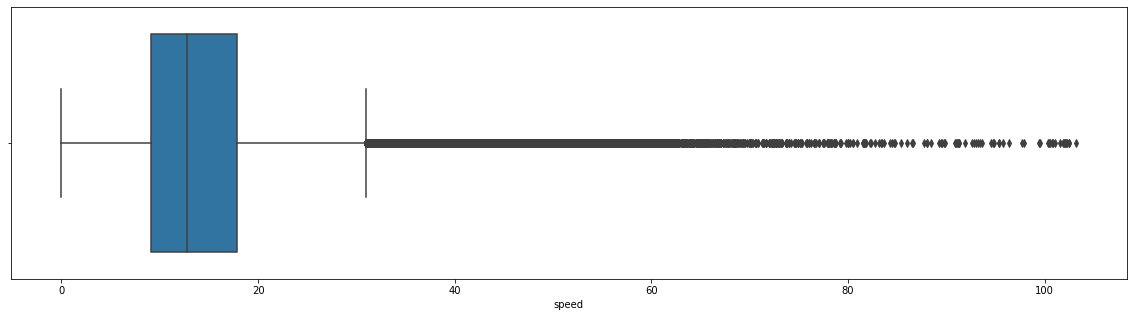

In [73]:
# Selecting data where speed is less than or equal to 104 km/hr and plotting again
df = df[df['speed'] <= 104] 
plt.figure(figsize = (20,5))
sns.boxplot(df.speed) 
plt.show()

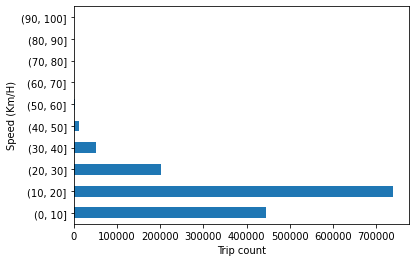

In [51]:
# plotting in group with respect to count
df.speed.groupby(pd.cut(df.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

Most of the trips are done under 0-20 km/hr and above 40 km/hr are all outliers but still they are under the 104 km/hr which is the maximum speed limit.

# Bivariate analysis

### trip duration per vendor

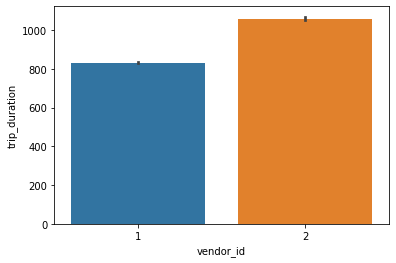

In [52]:
sns.barplot(x= "vendor_id", y="trip_duration",data=df)

We can observe vendor_id number 2 has done longer trips compared to vendor 1

### trip duration per store and forward flag

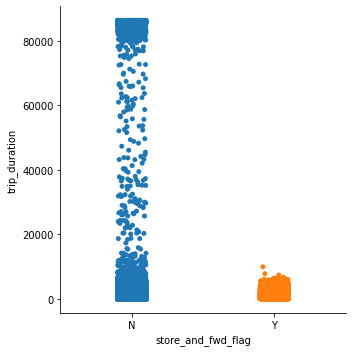

In [53]:
# plotting using catplot since bar plot was'nt able to capture those less scattered data points
sns.catplot(x="store_and_fwd_flag",y="trip_duration",data=df, kind="strip")

Trip duration is generally longer for trips whose flag was not stored

### Trip duration per passenger count

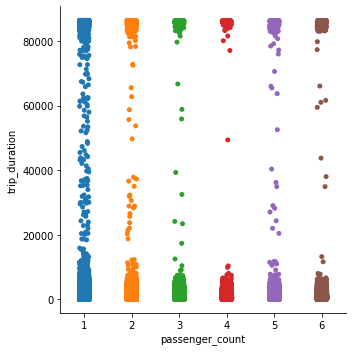

In [54]:
# plot for trip_duration vs passenger count
sns.catplot(x="passenger_count",y="trip_duration",data=df, kind="strip")

No valid relationship with trip_duration and passenger count

###Trip Duration per hour 

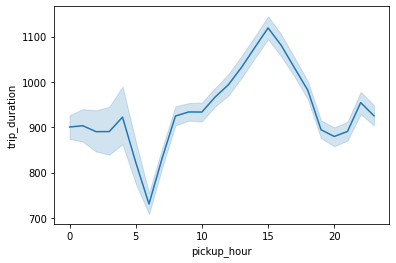

In [55]:
# plotting lineplot for Trip Duration vs hour 
sns.lineplot(x="pickup_hour", y="trip_duration", data=df)

We can observe that trip duration is maximum at 3pm which might be because of traffic issues, and trip duration in morning 6am is low because of less traffic

In [74]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_hour', 'dropoff_hour', 'pickup_month',
       'dropoff_month', 'pickup_time_of_the_day', 'dropoff_time_of_the_day',
       'distance', 'speed'],
      dtype='object')

### Trip_duration per period of time in a day

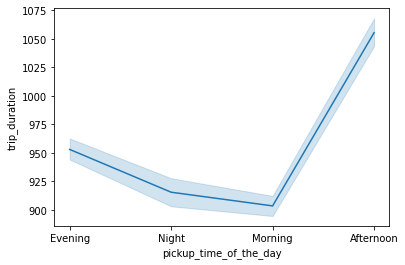

In [57]:
# plotting lineplot for Trip_duration vs time of the day
sns.lineplot(x="pickup_time_of_the_day", y='trip_duration', data=df)

Trip duration is lowest in morning time , lower in night and evening as compared to afternoon

### Trip Duration per Day of the Week

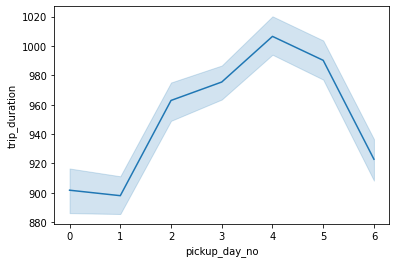

In [58]:
# Plotting lineplot for Trip_duration per day of the week
sns.lineplot(x="pickup_day_no", y='trip_duration', data=df)



Trip duration is longest on Thursday and bit lower on Friday

### Trip Duration per Month

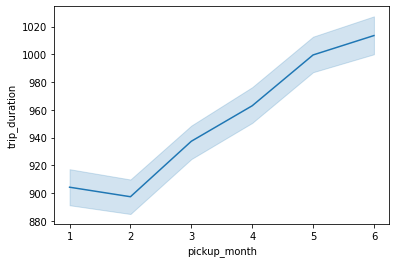

In [59]:
# plotting lineplot for trip_duration vs month
sns.lineplot(x="pickup_month", y='trip_duration', data=df)


From February, we see trip_duration is gradually rising every month

### Trip Duration vs Distance

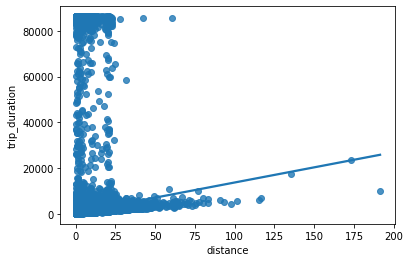

In [60]:
# plotting regplot for continous variable
sns.regplot(x= "distance", y="trip_duration", data=df)

We can clearly tell that trips with distance as short as 0 seconds and yet covering a large trip_duration

### Distance vs Trip Duration

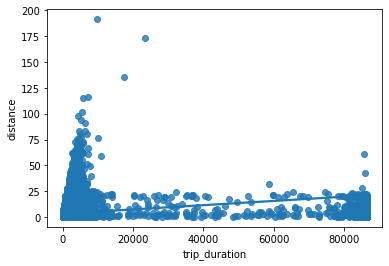

In [61]:
sns.regplot(x= "trip_duration", y="distance", data=df)

It seems like there is some linear relationship btw distance and trip_duration, yet there is no homoscedasticity (same variance) which breaks the assumption of linear regression

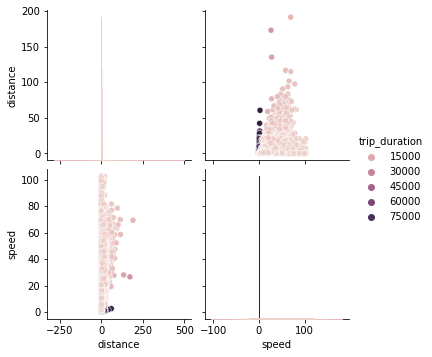

In [62]:
sns.pairplot(df,vars=["distance","speed"], hue= "trip_duration")

We can observe some data with speed 0km/hr and distance ranging from 0 to aprox of 60km which has a trip duration around 75000 seconds(almost 21 hrs)

The diagonal plots are variable plot to itself (ie,distance vs distance and speed vs speed), left bottom plot is speed vs distance plot and data points scattered within are respect to trip_duration, similarly the other plot. Most of the trip duration is covered below 15000 seconds (almost 4hrs 20mins)

From the above regplot and pairplot we can clearly see distances with 0 has more trip duration

Let's remove distance with 0km and trip_duration above 60sec

Assuming that people who might have canceled after booking would'nt have taken more than a minute in duration

In [35]:
# Removing data as per our assumption 
df = df[~((df.distance ==0) & (df.trip_duration >=60))]
df[df["distance"] ==0][["distance","trip_duration"]]


,distance,trip_duration
1620,0.0,27
1728,0.0,19
2441,0.0,8
2625,0.0,6
3042,0.0,6
3261,0.0,7
4158,0.0,17
4892,0.0,5
7794,0.0,15
8618,0.0,10


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454414 entries, 0 to 1458643
Data columns (total 23 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   id                       1454414 non-null  object        
 1   vendor_id                1454414 non-null  int64         
 2   pickup_datetime          1454414 non-null  datetime64[ns]
 3   dropoff_datetime         1454414 non-null  datetime64[ns]
 4   passenger_count          1454414 non-null  int64         
 5   pickup_longitude         1454414 non-null  float64       
 6   pickup_latitude          1454414 non-null  float64       
 7   dropoff_longitude        1454414 non-null  float64       
 8   dropoff_latitude         1454414 non-null  float64       
 9   store_and_fwd_flag       1454414 non-null  object        
 10  trip_duration            1454414 non-null  int64         
 11  pickup_day               1454414 non-null  object        
 12  

In [37]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_day_no',
       'dropoff_day_no', 'pickup_month', 'dropoff_month', 'pickup_hour',
       'dropoff_hour', 'pickup_time_of_the_day', 'dropoff_time_of_the_day',
       'distance', 'speed'],
      dtype='object')

In [38]:
dataset_pre = df.copy()

In [79]:
pd.set_option("display.max_columns", 50)

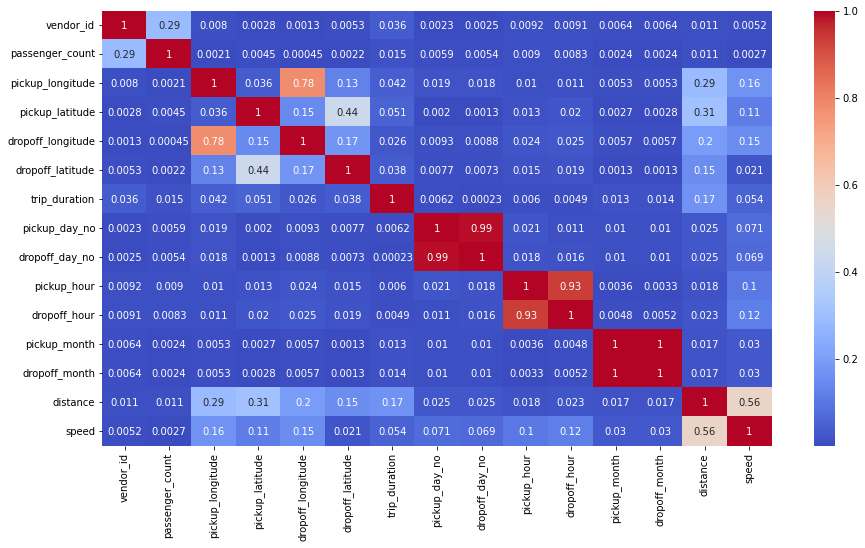

In [68]:
# plotting heatmap for checking multicollinarity
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Since there is more correlation between variables which is not likely for our linear regression model to predict, as it assumes to have less multicollinarity. We'll only take pickup data for month, hour, weekday_number and also lets drop speed (km/hr) because it is correlated with distance(km)

### One Hot Encoding

In [80]:
#label encoding
dataset_pre["store_and_fwd_flag_num"] = dataset_pre["store_and_fwd_flag"].map({"N": 0, "Y" : 1})
dataset_pre["vendor_id_onehot"] = dataset_pre["vendor_id"].map({2: 1, 1 : 0})

In [81]:
# One hot encoding
dataset_pre = pd.get_dummies(dataset_pre, columns=["pickup_day_no","pickup_month","pickup_time_of_the_day"],
                             prefix=["weekday_num","month_no","pickup"])

In [82]:
dataset_pre.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,dropoff_day_no,pickup_hour,dropoff_hour,dropoff_month,dropoff_time_of_the_day,distance,speed,store_and_fwd_flag_num,vendor_id_onehot,weekday_num_0,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,month_no_1,month_no_2,month_no_3,month_no_4,month_no_5,month_no_6,pickup_Afternoon,pickup_Evening,pickup_Morning,pickup_Night
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,1,17,17,3,Evening,1.498523,11.856445,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,0,0,0,6,Night,1.805510,9.803673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,2,11,12,1,Afternoon,6.385108,10.822216,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,3,19,19,4,Evening,1.485501,12.465739,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,6,13,13,3,Afternoon,1.188590,9.836608,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [83]:
dataset_pre.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'dropoff_day_no',
       'pickup_hour', 'dropoff_hour', 'dropoff_month',
       'dropoff_time_of_the_day', 'distance', 'speed',
       'store_and_fwd_flag_num', 'vendor_id_onehot', 'weekday_num_0',
       'weekday_num_1', 'weekday_num_2', 'weekday_num_3', 'weekday_num_4',
       'weekday_num_5', 'weekday_num_6', 'month_no_1', 'month_no_2',
       'month_no_3', 'month_no_4', 'month_no_5', 'month_no_6',
       'pickup_Afternoon', 'pickup_Evening', 'pickup_Morning', 'pickup_Night'],
      dtype='object')

In [84]:
# Removing most correlated variables 
dataset_pre = dataset_pre.drop(["id","vendor_id","pickup_datetime","dropoff_datetime","store_and_fwd_flag","pickup_day","dropoff_day"
,"dropoff_day_no","dropoff_hour","dropoff_month","dropoff_time_of_the_day","speed"],axis= 1)


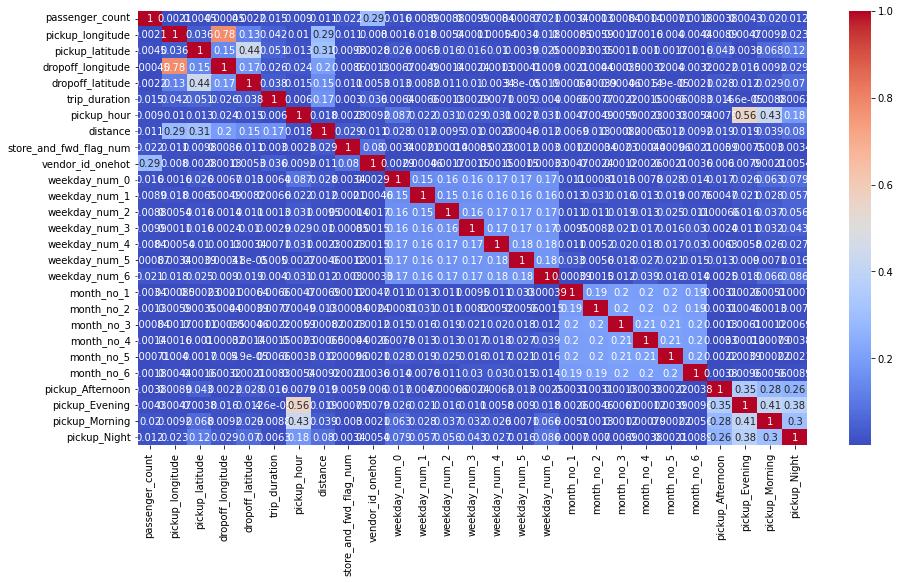

In [74]:
# plotting Heatmap after creating dummies and removing most correlated features
plt.figure(figsize=(15,8))
correlation = dataset_pre.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

Now it looks better than before, but still dropoff longitute and pickup longitute have 0.72 correlation, lets let it be its our coordinates of loaction so

In [79]:
# For calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

  ''' Creates a DataFrame with VIF values for
       their corresponding columns '''
    
  vif = pd.DataFrame()
  vif["variables"] = X.columns
  vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  return(vif)

In [76]:
calc_vif(dataset_pre[[i for i in dataset_pre.describe().columns if i not in ['trip_duration']]])

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,passenger_count,1.091636
1,pickup_longitude,2.708835
2,pickup_latitude,1.392480
3,dropoff_longitude,2.666202
4,dropoff_latitude,1.264849
5,pickup_hour,1.623125
6,distance,1.240485
7,store_and_fwd_flag_num,1.007459
8,vendor_id_onehot,1.097226
9,weekday_num_0,inf


VIF value is also below 5 which is good by theoritical knowledge ie, if VIF value is equal to 1 then not correlated, between  1-5 moderately correlated, above 5 is higly correlated 

Some values are infinity because of one hot encoding and formula for VIF is 1/(1-R-Squared) if R-Squared is 1, Where R-squared is given by the formula 1 - (MSE(model) / MSE(Baseline))

### Creating X and Y for our Linear Model

In [85]:
# Splitting Features (X and Y),  Rescaling inputs
from scipy.stats import zscore # Scaling our data with zscore 
X = dataset_pre[[i for i in dataset_pre.describe().columns if i not in ['trip_duration']]].apply(zscore)  # Standarization
y = np.log10(dataset_pre["trip_duration"]) # Log Transformation for better prediction

In [86]:
X.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,distance,store_and_fwd_flag_num,vendor_id_onehot,weekday_num_0,weekday_num_1,weekday_num_2,weekday_num_3,weekday_num_4,weekday_num_5,weekday_num_6,month_no_1,month_no_2,month_no_3,month_no_4,month_no_5,month_no_6,pickup_Afternoon,pickup_Evening,pickup_Morning,pickup_Night
0,-0.505539,-0.126386,0.597285,0.131833,0.421173,0.530300,-0.492569,-0.074454,0.933697,-0.393265,2.604126,-0.401770,-0.410256,-0.419815,-0.425398,-0.422437,-0.432238,-0.441884,2.166129,-0.456635,-0.453203,-0.437413,-0.497538,1.406128,-0.569751,-0.532051
1,-0.505539,-0.100835,-0.435629,-0.388700,-0.633192,-2.125952,-0.414943,-0.074454,-1.071011,2.542817,-0.384006,-0.401770,-0.410256,-0.419815,-0.425398,-0.422437,-0.432238,-0.441884,-0.461653,-0.456635,-0.453203,2.286166,-0.497538,-0.711173,-0.569751,1.879520
2,-0.505539,-0.080439,0.456702,-0.476101,-1.277882,-0.407201,0.743078,-0.074454,0.933697,-0.393265,-0.384006,2.488985,-0.410256,-0.419815,-0.425398,-0.422437,2.313538,-0.441884,-0.461653,-0.456635,-0.453203,-0.437413,-0.497538,-0.711173,1.755154,-0.532051
3,-0.505539,-0.535987,-1.089451,-0.579684,-1.380972,0.842801,-0.495862,-0.074454,0.933697,-0.393265,-0.384006,-0.401770,2.437504,-0.419815,-0.425398,-0.422437,-0.432238,-0.441884,-0.461653,2.189934,-0.453203,-0.437413,-0.497538,1.406128,-0.569751,-0.532051
4,-0.505539,0.007309,1.485994,0.007967,0.938957,-0.094700,-0.570941,-0.074454,0.933697,-0.393265,-0.384006,-0.401770,-0.410256,-0.419815,-0.425398,2.367216,-0.432238,-0.441884,2.166129,-0.456635,-0.453203,-0.437413,2.009896,-0.711173,-0.569751,-0.532051


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


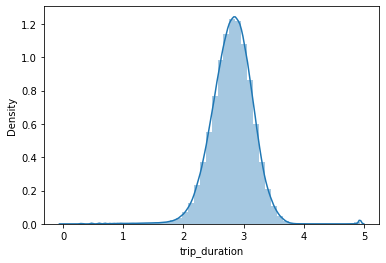

In [92]:
sns.distplot(y)

### Splitting data for traning and testing for model prediction 

In [87]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0) 

In [88]:
print(X_train.shape)
print(X_test.shape)

(1163404, 26)
(290852, 26)


In [89]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

In [90]:
y_pred = reg.predict(X_test)

In [91]:
from sklearn.metrics import mean_squared_error

MSE  = mean_squared_error(10**(y_test), 10**(y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MSE : 6.776251521121694e+21
RMSE : 82317990264.10748


In [92]:
from sklearn.preprocessing import PolynomialFeatures

In [47]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [69]:
poly_X = df[["distance","speed"]]
poly_y = df["trip_duration"]

In [70]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly.fit_transform(poly_X)
poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(poly_features, poly_y, test_size=0.3, random_state=42)

In [71]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_X_train, poly_y_train)

LinearRegression()

In [72]:
poly_reg_y_predicted = poly_reg_model.predict(poly_X_test)
from sklearn.metrics import mean_squared_error
poly_reg_rmse = np.sqrt(mean_squared_error(poly_y_test, poly_reg_y_predicted))
poly_reg_rmse

3233.0382202663163

In [73]:
poly_reg_model.intercept_

1356.1071987454761

In [63]:
poly_reg_y_predicted.shape

(436325,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


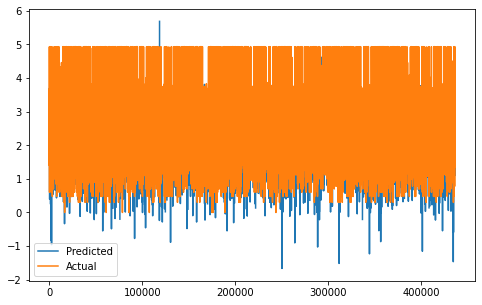

In [82]:
plt.figure(figsize=(8,5))
plt.plot(np.log10(poly_reg_y_predicted))
plt.plot(np.array(np.log10(poly_y_test)))
plt.legend(["Predicted","Actual"])
plt.show()

